In [1]:
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
print(sns.get_dataset_names())

['anscombe', 'attention', 'brain_networks', 'car_crashes', 'diamonds', 'dots', 'exercise', 'flights', 'fmri', 'gammas', 'geyser', 'iris', 'mpg', 'penguins', 'planets', 'tips', 'titanic']


In [3]:
flight_data = sns.load_dataset("flights")
flight_data.head()

,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132
3,1949,April,129
4,1949,May,121


In [4]:
flight_data.shape

(144, 3)

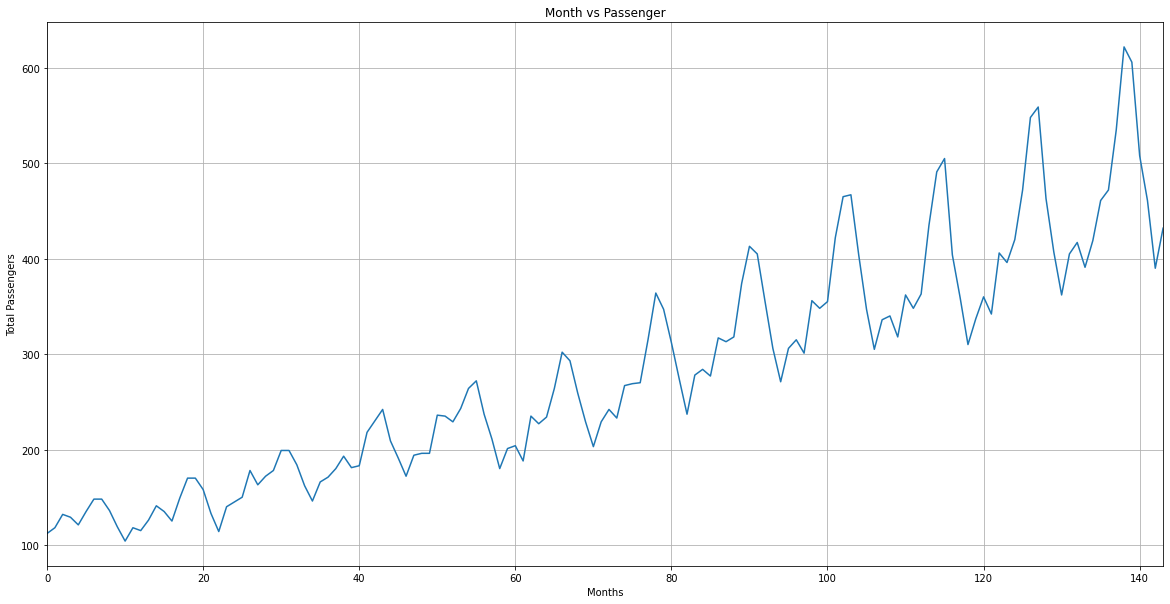

In [5]:
plt.figure(figsize=(20,10))
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.xlabel('Months')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(flight_data['passengers'])

In [6]:
flight_data.shape

(144, 3)

### Data Preprocessing

In [6]:
all_data = flight_data['passengers'].values.astype(float)

In [7]:
print(all_data)

[112. 118. 132. 129. 121. 135. 148. 148. 136. 119. 104. 118. 115. 126.
 141. 135. 125. 149. 170. 170. 158. 133. 114. 140. 145. 150. 178. 163.
 172. 178. 199. 199. 184. 162. 146. 166. 171. 180. 193. 181. 183. 218.
 230. 242. 209. 191. 172. 194. 196. 196. 236. 235. 229. 243. 264. 272.
 237. 211. 180. 201. 204. 188. 235. 227. 234. 264. 302. 293. 259. 229.
 203. 229. 242. 233. 267. 269. 270. 315. 364. 347. 312. 274. 237. 278.
 284. 277. 317. 313. 318. 374. 413. 405. 355. 306. 271. 306. 315. 301.
 356. 348. 355. 422. 465. 467. 404. 347. 305. 336. 340. 318. 362. 348.
 363. 435. 491. 505. 404. 359. 310. 337. 360. 342. 406. 396. 420. 472.
 548. 559. 463. 407. 362. 405. 417. 391. 419. 461. 472. 535. 622. 606.
 508. 461. 390. 432.]


The first 132 records will be used to train the model and the last 12 records will be used as a test set. 

In [8]:
test_data_size = 12

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]
print(len(train_data))
print(len(test_data))

132
12


In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data.reshape(-1, 1))

In [10]:
print(train_data_normalized[:5])
print(train_data_normalized[-5:])

[[-0.96483516]
 [-0.93846154]
 [-0.87692308]
 [-0.89010989]
 [-0.92527473]]
[[1.        ]
 [0.57802198]
 [0.33186813]
 [0.13406593]
 [0.32307692]]


In [11]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [14]:
train_window = 12

In [15]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [16]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [17]:
train_inout_seq[:2]

[(tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
          -0.8593, -0.9341, -1.0000, -0.9385]),
  tensor([-0.9516])),
 (tensor([-0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593,
          -0.9341, -1.0000, -0.9385, -0.9516]),
  tensor([-0.9033]))]

### Creating LSTM Model

In [37]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [38]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [39]:
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [40]:
epochs = 200

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
#         print(seq.shape)
        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00132574
epoch:  26 loss: 0.00881314
epoch:  51 loss: 0.02416172
epoch:  76 loss: 0.00005329
epoch: 101 loss: 0.00240469
epoch: 126 loss: 0.00071957
epoch: 151 loss: 0.00001457
epoch: 176 loss: 0.00004064
epoch: 199 loss: 0.0000166812


In [42]:
fut_pred = 12

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[0.12527473270893097, 0.04615384712815285, 0.3274725377559662, 0.2835164964199066, 0.3890109956264496, 0.6175824403762817, 0.9516483545303345, 1.0, 0.5780220031738281, 0.33186814188957214, 0.13406594097614288, 0.32307693362236023]


In [43]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [44]:
test_inputs[fut_pred:]

[0.6076171398162842,
 0.47572651505470276,
 0.5026208162307739,
 0.6594032049179077,
 0.8431598544120789,
 1.175675868988037,
 1.2838572263717651,
 1.5947685241699219,
 1.5213773250579834,
 1.273705005645752,
 1.3929388523101807,
 1.3276042938232422]

In [45]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

[[469.73289931]
 [439.72778217]
 [445.84623569]
 [481.51422912]
 [523.31886688]
 [598.96626019]
 [623.577519  ]
 [694.30983925]
 [677.61334145]
 [621.26788878]
 [648.3935889 ]
 [633.52997684]]


In [46]:
x = np.arange(132, 144, 1)
print(x)

[132 133 134 135 136 137 138 139 140 141 142 143]


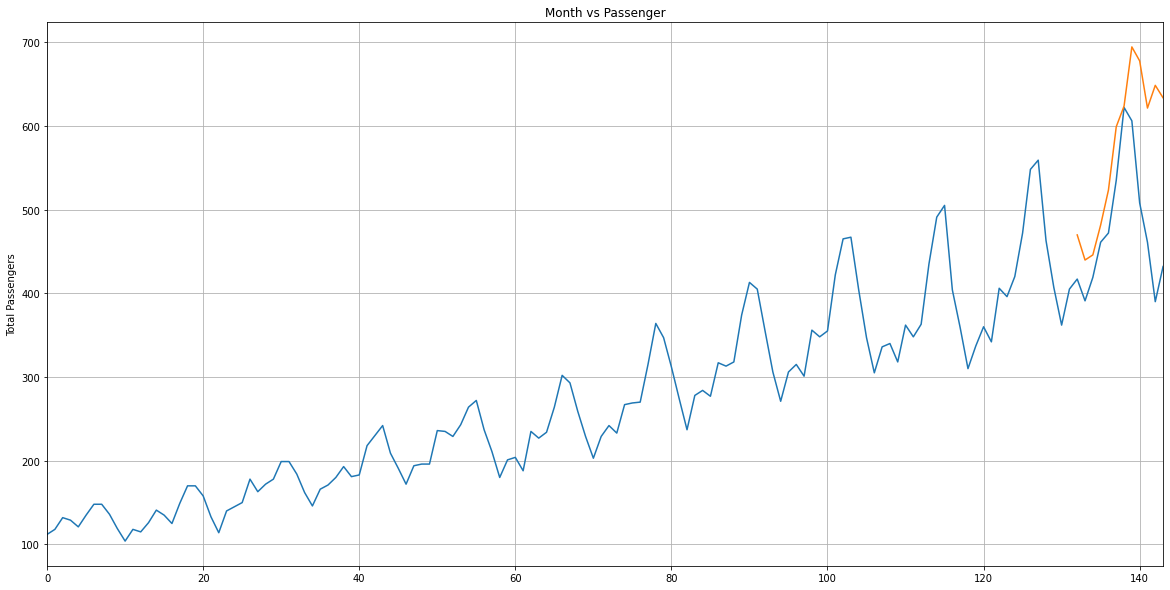

In [47]:
plt.figure(figsize=(20,10))
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'])
plt.plot(x,actual_predictions)
plt.show()

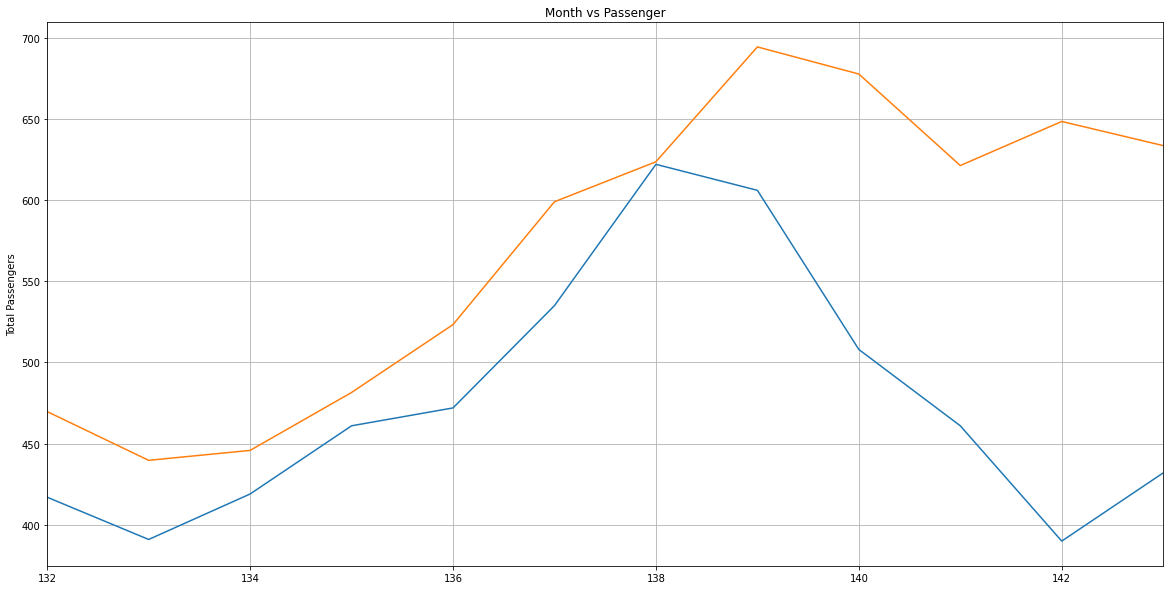

In [48]:
plt.figure(figsize=(20,10))
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(flight_data['passengers'][-train_window:])
plt.plot(x,actual_predictions)
plt.show()